# XGBOOST

In [75]:
import numpy as np
import pandas as pd
import yfinance as yf
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import plot_importance

## calculation of XGBOOST

[*********************100%***********************]  1 of 1 completed


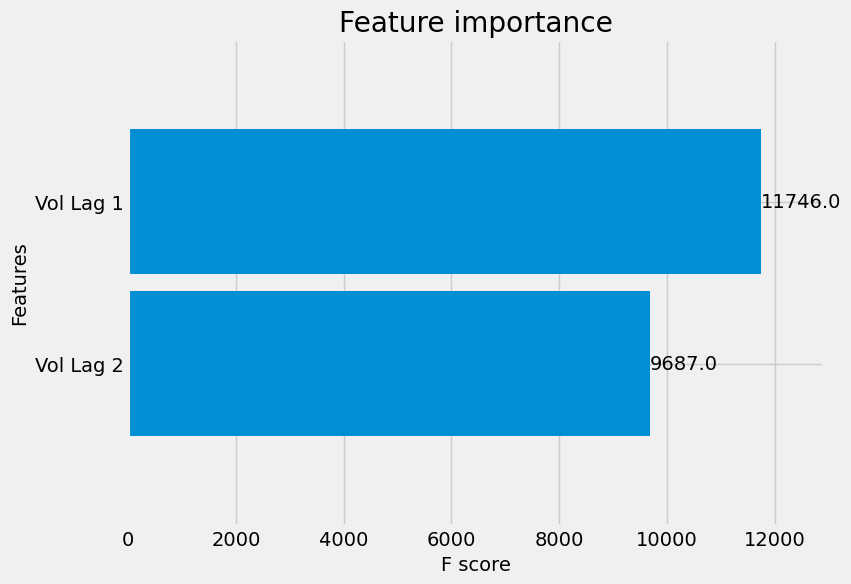

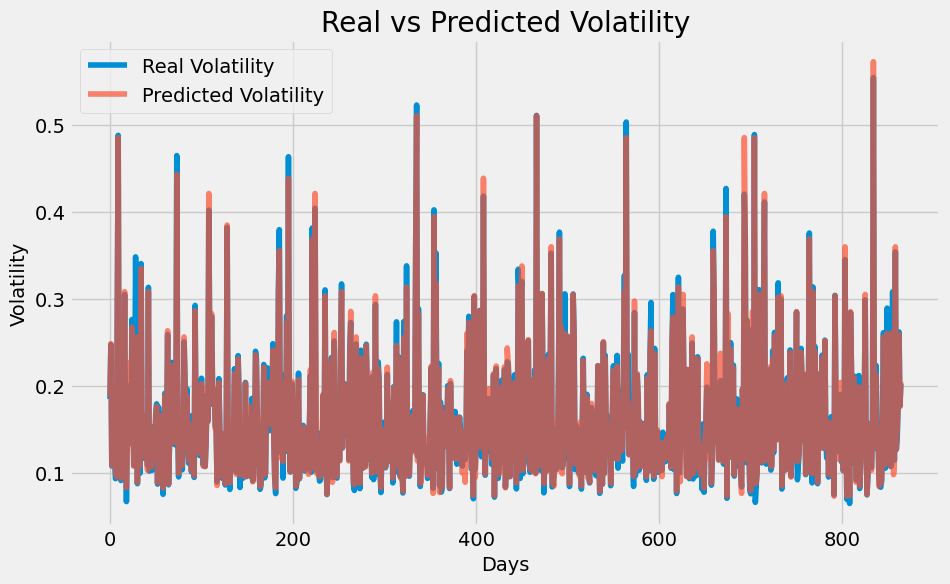

In [77]:
# Download the data
df = yf.download('GLD', start='2007-01-01')

# Calculate daily returns
df['Returns'] = df['Adj Close'].pct_change()

# Calculate historical volatility (rolling standard deviation of returns)
window_size = 22  # A common choice is 22 trading days in a month
df['Historical Volatility'] = df['Returns'].rolling(window=window_size).std() * np.sqrt(252)  # Annualize the volatility

# Drop NaN values
df.dropna(inplace=True)

# Feature Engineering: Use lagged volatilities as features
df['Vol Lag 1'] = df['Historical Volatility'].shift(1)
df['Vol Lag 2'] = df['Historical Volatility'].shift(2)

# Ensure no NaN values
df.dropna(inplace=True)

# Defining features and target variable
X = df[['Vol Lag 1', 'Vol Lag 2']]
y = df['Historical Volatility']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the XGBoost regressor
regressor = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, objective='reg:squarederror')
regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)

# Predicting volatility
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

# Plot of feature importance
fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(regressor, height=0.9, ax=ax)
plt.show()

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    'Real Volatility': y_test,
    'Predicted Volatility': y_pred_test
}).reset_index(drop=True)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Real Volatility'], label='Real Volatility')
plt.plot(comparison_df['Predicted Volatility'], label='Predicted Volatility', alpha=0.7)
plt.title('Real vs Predicted Volatility')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend()
plt.show()


### Forecast XGBOOST

Train MSE: 0.0001
Test MSE: 0.0001
Train RMSE: 0.0096
Test RMSE: 0.0073
Train MAE: 0.0055
Test MAE: 0.0044
Train MAPE: 3.58%
Test MAPE: 4.06%


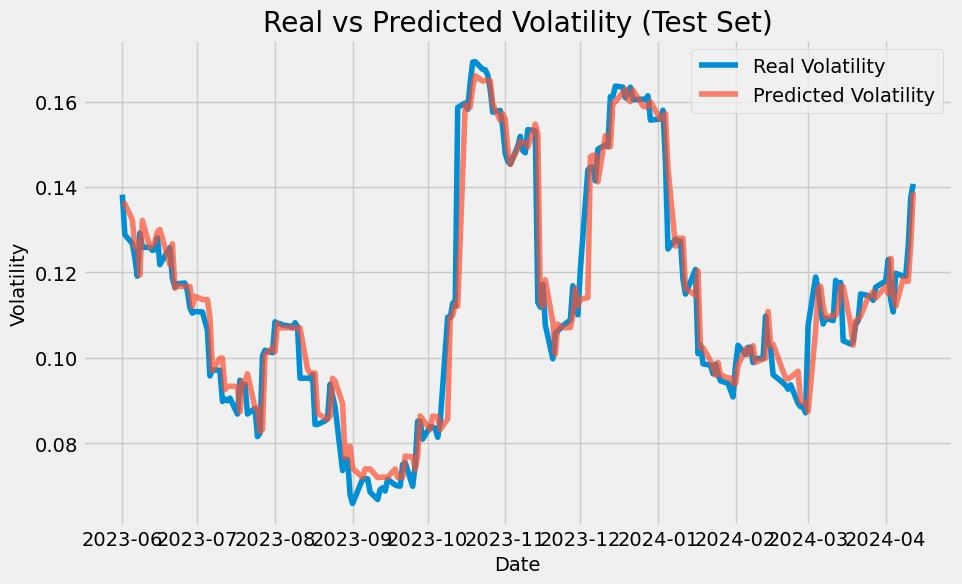

In [74]:

# Feature Engineering: Use lagged volatilities as features
df['Vol Lag 1'] = df['Historical Volatility'].shift(1)
df['Vol Lag 2'] = df['Historical Volatility'].shift(2)

# Ensure no NaN values
df.dropna(inplace=True)

# Defining features and target variable
X = df[['Vol Lag 1', 'Vol Lag 2']]
y = df['Historical Volatility']

# Define the cutoff date for training data
cutoff_date = pd.Timestamp('2023-05-31')

# Split the data based on the cutoff date
X_train = X.loc[:cutoff_date]
y_train = y.loc[:cutoff_date]
X_test = X.loc[cutoff_date + pd.Timedelta(days=1):]
y_test = y.loc[cutoff_date + pd.Timedelta(days=1):]

# Initialize and fit the XGBoost regressor
regressor = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, objective='reg:squarederror')
regressor.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)

# Predicting volatility
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.inf

# Evaluate the model using RMSE, MAE, and MAPE
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f'Train MSE: {mse_train:.4f}')
print(f'Test MSE: {mse_test:.4f}')
print(f'Train RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')
print(f'Train MAE: {mae_train:.4f}')
print(f'Test MAE: {mae_test:.4f}')
print(f'Train MAPE: {mape_train:.2f}%')
print(f'Test MAPE: {mape_test:.2f}%')

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    'Real Volatility': y_test,
    'Predicted Volatility': y_pred_test
}, index=y_test.index)  # maintain the index for plotting

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Real Volatility'], label='Real Volatility')
plt.plot(comparison_df['Predicted Volatility'], label='Predicted Volatility', alpha=0.7)
plt.title('Real vs Predicted Volatility (Test Set)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()
